In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from argparse import Namespace
from tqdm.notebook import tqdm
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import preds_targets_zn, PlottingContext, IO, get_rms
from copy import deepcopy

experiment_name = "experiments/freeze_emb2"


  0%|          | 0/100000 [00:00<?, ?it/s]

tensor([[56, 81,  8],
        [56, 81,  9],
        [57, 80,  8],
        [57, 80,  9],
        [57, 81,  0],
        [57, 81,  8],
        [57, 81,  9],
        [57, 82,  8],
        [57, 82,  9],
        [58, 81,  8],
        [58, 81,  9]], device='cuda:0')
Epoch 0: 2868.90
0 2868.8974609375 38125.00390625


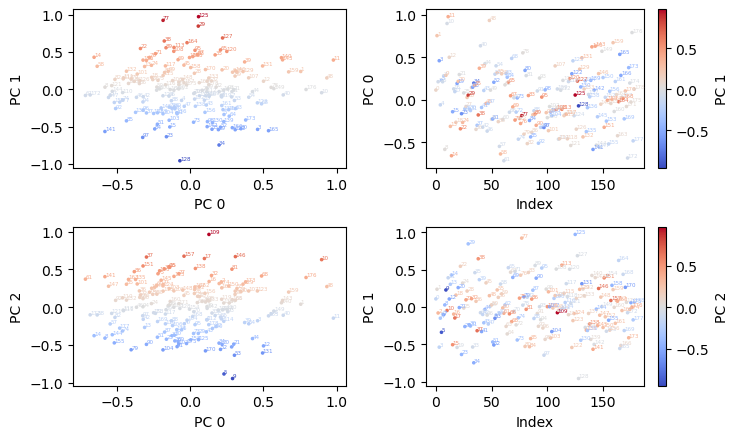

KeyboardInterrupt: 

In [2]:
train_embeddings_only = True

def set_trainable(model, train_embeddings_only):
    if train_embeddings_only:
        # Freeze all parameters in the model
        for param in model.parameters():
            param.requires_grad = False

        # Assuming model.emb is a Parameter or a Tensor, directly set requires_grad
        if hasattr(model.emb, 'requires_grad'):
            model.emb.requires_grad = True

        # If model.emb is a module containing parameters, set requires_grad for all its parameters
        elif hasattr(model.emb, 'parameters'):
            for param in model.emb.parameters():
                param.requires_grad = True
                
        # for name, param in model.named_parameters():
        #     if name=="emb.2":
        #         param.requires_grad = False
                
# Function to evaluate and print the RMS for a model
def evaluate_and_print_rms(model, task, data, description):
    preds, targets, zn = preds_targets_zn(data, model, task, train=True)
    preds_pn = preds/zn.sum(1).reshape(-1,1)
    targets_pn = targets/zn.sum(1)
    rms = get_rms(preds_pn, targets_pn, zn, scale_by_A=False)
    print(f"{description} RMS: {rms:.2f}")

def train_model(task, mult_factors, run_name):
    
    # Define your current training configuration
    # Load arguments from the pretrained model
    pretrained_args = IO.load_args(f"/work/submit/karich/experiments/long-runs/leave-one-out-81-57-leave-in-be-more-epochs/args.yaml")
    pretrained_args = vars(pretrained_args)

    args = {}
    args.update(pretrained_args)
        
    args = Namespace(**args)
    data = prepare_nuclear_data(args, mult_factors)
    model, optim_model = get_model_and_optim(data, args)

    torch.manual_seed(args.SEED)
    X_train = data.X[data.train_mask]
    y_train = data.y[data.train_mask]
    non_nan_targets = ~torch.isnan(y_train.view(-1))
    X_train = X_train[non_nan_targets]
    y_train = y_train[non_nan_targets]

    set_trainable(model, train_embeddings_only)
    epochs = args.EPOCHS
    for epoch in (pbar:=tqdm(range(epochs))):        
        optim_model.zero_grad()
        preds = model(X_train)
        preds = preds.gather(1, X_train[:, 2].long().view(-1, 1))
        
        # Calculate RMS in a way that is consistent with get_rms
        zn = X_train[:, :2].sum(1, keepdim=True)
        preds_pn = preds / zn
        y_train_pn = y_train / zn
        diff = preds_pn - y_train_pn
        loss = torch.sqrt(torch.mean(diff ** 2))
        
        loss.backward()
        optim_model.step()
        
        if epoch % 100 == 0:
            X_test = data.X[~data.train_mask]
            y_test = data.y[~data.train_mask]
            non_nan_targets = ~torch.isnan(y_test.view(-1))
            X_test = X_test[non_nan_targets]
            y_test = y_test[non_nan_targets]
            preds = model(X_test)
            preds = preds.gather(1, X_test[:, 2].long().view(-1, 1))
            zn = X_test[:, :2].sum(1, keepdim=True)
            preds_pn = preds / zn
            y_test_pn = y_test / zn
            diff = preds_pn - y_test_pn
            
            smoothness_penalty = 0
            for i in range(len(zn)):
                for j in range(len(zn)):
                    if zn[i] == zn[j]+1:
                        smoothness_penalty += abs(diff[i])
                        
            test_loss = torch.sqrt(torch.mean(diff ** 2))+smoothness_penalty
            
            s = str(epoch)+' '+str(loss.item())+' '+str(test_loss.item())+"\n"
            os.write(1, s.encode())


        if epoch % (epochs // 10) == 0:
            print(f"Epoch {epoch}: {loss.item():.2f}")
            # evaluate_and_print_rms(model, task, data, f"Train RMS {task}")
            embed = model.emb[1].detach().cpu().numpy()
            PlottingContext.plot_embedding(embed, num_components=3, figscale=0.5); plt.show()

    pbar.set_description(f"Epoch {epoch}: {loss.item():.2e}")
    
    os.makedirs(f"/work/submit/karich/experiments/long-runs/leave-one-out-81-57-leave-in-be-more-epochs/{run_name}", exist_ok=True)
    torch.save(model.state_dict(), f"/work/submit/karich/experiments/long-runs/leave-one-out-81-57-leave-in-be-more-epochs/{run_name}/model.pt")
    IO.save_args(args, f"/work/submit/karich/experiments/long-runs/leave-one-out-81-57-leave-in-be-more-epochs/{run_name}/args.yaml")

mult_factors = [1.0, 1.0, 1.0, 1.0, 1.0]  # Default values for volume, surface, coulomb, pauli, pairing

terms = ['volume', 'surface', 'coulomb', 'pauli', 'pairing']
    

train_model("binding", mult_factors, "ckpts")

